In [23]:
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torch
from numpy import zeros, array, vstack
import numpy as np
import torch.utils.data as data_utils
from torch import Tensor
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
root = Path(".").resolve().absolute()
jorge_path = root / "jorge"
jorge_dst_path = root / "jorge_100"
marissa_path = root / "marissa"
marissa_dst_path = root / "marissa_100"

In [4]:
for f in jorge_path.iterdir():
    old_image = cv2.imread(str(f))
    image = cv2.resize(old_image, (100,100))
    cv2.imwrite(str(jorge_dst_path / f.name), image)

In [5]:
for f in marissa_path.iterdir():
    old_image = cv2.imread(str(f))
    image = cv2.resize(old_image, (100,100))
    cv2.imwrite(str(marissa_dst_path / f.name), image)


In [29]:
all_arrays = []
train_arrays = []
test_arrays = []
for f in jorge_dst_path.iterdir():
    all_arrays.append(cv2.imread(str(f))[:, :, 0].flatten())
train_arrays = all_arrays[:250]
test_arrays = all_arrays[250:]
for f in marissa_dst_path.iterdir():
    all_arrays.append(cv2.imread(str(f))[:, :, 0].flatten())
train_arrays += all_arrays[300:550]
test_arrays += all_arrays[550:]

all_arrays = vstack(all_arrays)
train_arrays = vstack(train_arrays)
test_arrays = vstack(test_arrays)
len(test_arrays)

100

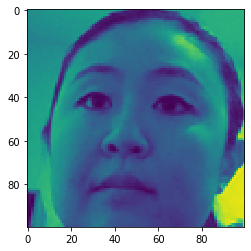

In [9]:
plt.imshow(np.split(train_arrays[-30], 100))

In [21]:
train = torch.tensor(train_arrays)
train_target = torch.tensor(np.concatenate((zeros(250), np.ones(250))))
train_tensor = data_utils.TensorDataset(train, train_target) 
trainset = data_utils.DataLoader(dataset = train_tensor, batch_size = 10, shuffle = True)
# train_tensor.tensors

In [38]:
test = torch.tensor(test_arrays)
test_target = torch.tensor(np.concatenate((zeros(50), np.ones(50))))
test_tensor = data_utils.TensorDataset(test, test_target) 
testset = data_utils.DataLoader(dataset = test_tensor, batch_size = 1, shuffle = True)
# train_tensor.tensors

In [13]:
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(100 * 100, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [27]:
net = Net()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.parameters()

<generator object Module.parameters at 0x7f6991d12a50>

In [28]:
for epoch in range(3):
    for X, y in trainset:
        net.zero_grad() 
        output = net(X.float()) 
        loss = F.nll_loss(output, y.long()) 
        loss.backward()
        optimizer.step()
    print(loss)

tensor(1.1921e-08, grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(3.5763e-08, grad_fn=<NllLossBackward>)


In [39]:
correct = 0
total = 0
with torch.no_grad():
    for X, y in testset:
        output = net(X.float())
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  1.0


In [67]:
%%time
with torch.no_grad():
    index = -15
    # plt.imshow(np.split(test_arrays[index], 100))
    t = torch.tensor([test_arrays[index]])
    output = net(t.float())
    if torch.argmax(output) == 0:
        print("IS JORGE")
    else:
        print("IS MARISSA")

IS MARISSA
CPU times: user 4.52 ms, sys: 1.85 ms, total: 6.37 ms
Wall time: 2.95 ms
